In [1]:
import os
from shutil import copy2
import csv

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [13]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [14]:
import tensorflow_hub as hub

In [15]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [16]:
!unzip '/content/drive/MyDrive/archive (2)' -d '/content/'

Archive:  /content/drive/MyDrive/archive (2).zip
replace /content/Training_set/Training_set/electric bus/821c1f91.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
data_root = ("/content/training_set/Training_set")

In [18]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 296 images belonging to 2 classes.
Found 1190 images belonging to 2 classes.


In [7]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 2))

In [8]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'electric bus': 0, 'electric car': 1}


In [9]:
!cat labels.txt

electric bus
electric car

In [25]:
IMAGE_SIZE = [224, 224]

In [26]:
vgg = VGG16(input_shape = IMAGE_SIZE + [3], 
            weights = 'imagenet', 
            include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [27]:
for layer in vgg.layers:
    layer.trainable = False

In [28]:
folders = glob('/content/training_set/Training_set/*')

In [29]:
x = Flatten()(vgg.output)

In [30]:
prediction = Dense(len(folders), activation='softmax')(x)

In [32]:
model = Model(inputs=vgg.input, outputs=prediction)

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [34]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [35]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [36]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=50,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/50
38/38 [==============================] - 48s 254ms/step - loss: 0.8210 - acc: 0.7016 - val_loss: 0.0936 - val_acc: 0.9662
Epoch 2/50
38/38 [==============================] - 6s 156ms/step - loss: 0.0318 - acc: 0.9877 - val_loss: 0.0715 - val_acc: 0.9764
Epoch 3/50
38/38 [==============================] - 6s 157ms/step - loss: 0.0247 - acc: 0.9945 - val_loss: 0.1186 - val_acc: 0.9561
Epoch 4/50
38/38 [==============================] - 6s 159ms/step - loss: 0.0090 - acc: 0.9989 - val_loss: 0.0822 - val_acc: 0.9662
Epoch 5/50
38/38 [==============================] - 6s 159ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0751 - val_acc: 0.9730
Epoch 6/50
38/38 [==============================] - 6s 160ms/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0923 - val_acc: 0.9628
Epoch 7/50
38/38 [==============================] - 6s 159ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0837 - val_acc: 0.9730
Epoch 8/50
38/38 [==============================] - 6s 160ms/step - loss: 0

In [37]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

10/10 [==============================] - 1s 128ms/step - loss: 0.0882 - acc: 0.9730
Final loss: 0.09
Final accuracy: 97.30%


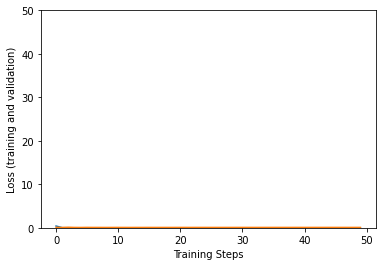

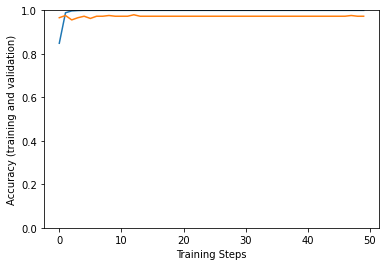

In [38]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [39]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [40]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Electric Bus' 'Electric Car']


In [41]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 2)


In [42]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Electric Bus' 'Electric Bus' 'Electric Bus' 'Electric Bus'
 'Electric Car' 'Electric Bus' 'Electric Car' 'Electric Car'
 'Electric Car' 'Electric Car' 'Electric Bus' 'Electric Bus'
 'Electric Bus' 'Electric Car' 'Electric Bus' 'Electric Car'
 'Electric Bus' 'Electric Car' 'Electric Bus' 'Electric Bus'
 'Electric Car' 'Electric Bus' 'Electric Bus' 'Electric Bus'
 'Electric Bus' 'Electric Bus' 'Electric Bus' 'Electric Bus'
 'Electric Car' 'Electric Bus' 'Electric Bus' 'Electric Bus']


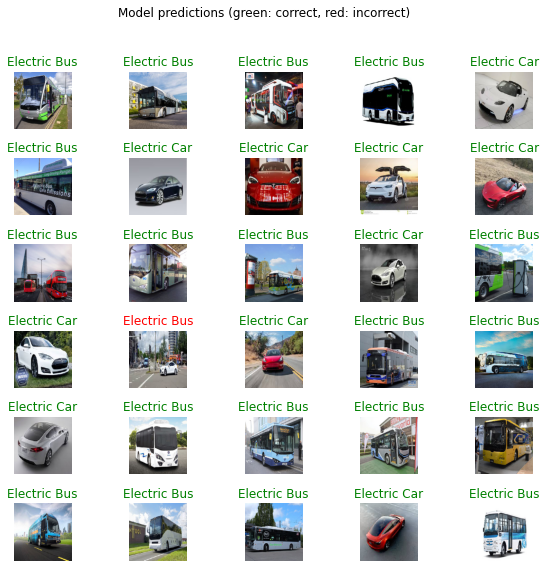

In [43]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")